In [15]:
import matplotlib.pyplot as plt
import numpy as np


pi = np.pi
exp = np.exp

def norm_dist(mean,variance):
    return lambda x: (1/(np.sqrt(2*pi*variance))) * exp(- ((x-mean)**2)/(2*variance) )

# Implémentation de métroplis

In [2]:
def metropolis(x0,distribution_cible,proposition, iterations = 1000):
    tirage = [x0]
    x_t = x0
    for _ in range(iterations):
        # tirage de x
        x = proposition(x_t)

        # a:= PI(x) / PI(x_t)
        p_x_t = distribution_cible(x_t)
        p_x = distribution_cible(x)
        if p_x_t == 0 : alpha = 1 # on évite la division par 0
        else : alpha = min(1,p_x/p_x_t)

        #on tire u de manière uniforme dans [0;1]
        u = np.random.uniform(0,1)

        # Si u <= a alors : x_(t+1) = x'
        # Sinon : x_(t+1) = x_t
        if u <= alpha : x_t = x
        tirage.append(x_t)

    return tirage


## Application

In [3]:
distribution_cible = lambda x: np.exp(-x**2 / 2)

proposition =lambda x: x +  np.random.normal(0,1)

tirage = metropolis(0,distribution_cible,proposition,iterations=100_000)

/tmp/ipykernel_1830/3884605829.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


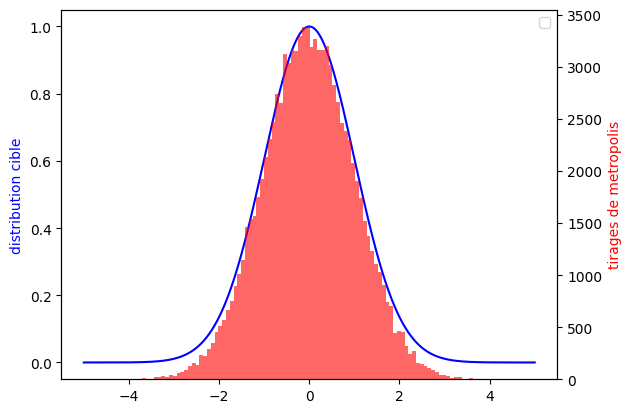

In [ ]:
fig, ax1 = plt.subplots()


X = np.linspace(-5,5,1000)
data1 = distribution_cible(X)
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.plot(X,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")

plt.legend()
plt.show()

## Algorithme de Metropolis-Hasting 

- Il faut avant tout choisir un point $x_0$, comme étant le premier échantillon de notre loi cible, et aussi une probabilité de transition $g$, en donnant les fonctions correspondant à $g_y(x)$ et $g(x)$, $\forall x,y \in \mathfrak{X}$.  

- Ensuite nous itérons sur $t$ allant de 0 à $N$ (notre nombre d'itérations voulu)  
    1. On tire $x$ avec $g_{x_t}(x)$  
    2. On pose $\alpha \coloneqq \frac{ \pi(x) g_x(x_t)}{\pi(x_t) g_{x_t}(x)}$ (notons que si nous ne possédons qu'une densité proportionnelle à $\pi$, $f$ nous pouvons poser $\alpha \coloneqq \frac{ f(x) g_x(x_t)}{f(x_t) g_{x_t}(x)}$)  
    3. On tire $u \in [0;1]$, tel que $u  \sim \mathcal{U}(0,1)$  -
        - Si $u \leqslant \alpha$ alors : $x_{t+1} \coloneqq x$  
        - Sinon : on conserve l'état précédent $x_{t+1} \coloneqq x$  
        
    
- La séquence $\{x_0,x_1, ... ,x_{N-1}\}$ constitue donc l'échantillon obtenue à partir de la chaîne de Markov associé à la loi $\pi$


Voici une implémentation de l'algorithme en python :

# Implémentation de hasting_metropolis :

In [ ]:
def hasting_metropolis(x0,distribution_cible,proposition,densite_proposition,iterations = 1000):
    x_t = x0
    tirage = [x_t]

    for _ in range(iterations):
        # tirage de x
        x = proposition(x_t)

        # a:= (PI(x)*g(x_t|x)) / (PI(x_t)*g(x|x_t))
        pi_xt = distribution_cible(x_t)
        pi_x = distribution_cible(x)
        g_xt_x = densite_proposition(x_t,x)
        g_x_xt = densite_proposition(x,x_t)
        if pi_xt * g_xt_x == 0 : alpha = 1 # on évite la division par 0
        else : alpha = min(1,(pi_x * g_x_xt)/(pi_xt * g_xt_x))

        #on tire u de manière uniforme dans [0;1]
        u = np.random.uniform(0,1)

        # Si u <= a alors : x_(t+1) = x'
        # Sinon : x_(t+1) = x_t
        if u <= alpha : x_t = x
        tirage.append(x_t)

    return tirage

## Application

In [ ]:
distribution_cible = norm_dist(2,2)

proposition =lambda x: x +  np.random.normal(0,1)
densite_proposition = lambda x, y: np.exp(-(y - x) ** 2 / 2) / np.sqrt(2 * np.pi)

tirage = hasting_metropolis(0,distribution_cible,proposition,densite_proposition,iterations=100_000)

/tmp/ipykernel_1830/1403776932.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


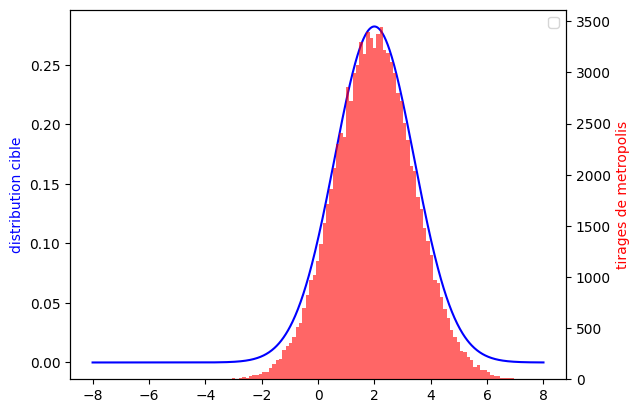

In [17]:
fig, ax1 = plt.subplots()

X = np.linspace(-8,8,1000)
data1 = distribution_cible(X)
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.plot(X,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")

plt.legend()
plt.show()

In [ ]:
(a,b) = (-3,3)

distribution_cible = lambda x: 1/(b-a) if a<=x and x<= b else 0

proposition =lambda x: x +  np.random.normal(0,1)
densite_proposition = lambda x, y: np.exp(-(y - x) ** 2 / 2) / np.sqrt(2 * np.pi)

tirage = hasting_metropolis(0,distribution_cible,proposition,densite_proposition,iterations=100_000)

/tmp/ipykernel_1830/1798238582.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


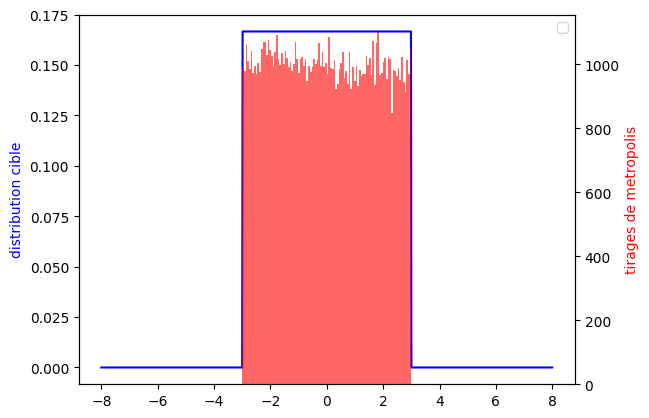

In [19]:
fig, ax1 = plt.subplots()

X = np.linspace(-8,8,1000)
data1 = [distribution_cible(x) for x in X]
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.plot(X,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")

plt.legend()
plt.show()